In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [42]:
def get_corners_of_images_with_match(first_img, second_img, pattern_size_cartesian):
    # find the max pattern size for both images
    first_img_max_pattern, second_img_max_pattern = None, None
    first_img_corners, second_img_corners = None, None
    for pattern_size in pattern_size_cartesian:
        first_ret, first_corners = cv2.findChessboardCorners(first_img, pattern_size, None)
        second_ret, second_corners = cv2.findChessboardCorners(second_img, pattern_size, None)
        if first_ret:
            first_img_max_pattern = pattern_size
            first_img_corners = first_corners

        if second_ret:
            second_img_max_pattern = pattern_size
            second_img_corners = second_corners

        if first_ret and second_ret:
            break
    return first_img_max_pattern, first_img_corners, second_img_max_pattern, second_img_corners

def plot_found_corners(first_img, first_img_max_pattern, first_img_corners, second_img, second_img_max_pattern, second_img_corners):
    first_rgb = cv2.cvtColor(first_img, cv2.COLOR_GRAY2RGB)
    first_rgb = cv2.drawChessboardCorners(first_rgb, first_img_max_pattern, first_img_corners, True)
    plt.figure(figsize=(5, 5))
    plt.imshow(first_rgb)

    second_rgb = cv2.cvtColor(second_img, cv2.COLOR_GRAY2RGB)
    second_rgb = cv2.drawChessboardCorners(second_rgb, second_img_max_pattern, second_img_corners, True)
    plt.figure(figsize=(5, 5))
    plt.imshow(second_rgb)

def get_homography(first_corner_matrix, second_corner_matrix):
    first_corner_matrix_third = np.ones((first_corner_matrix.shape[0], 1))
    first_corner_matrix_third = np.concatenate([first_corner_matrix, first_corner_matrix_third], axis=1)
    resulting_point_matrix = np.zeros((first_corner_matrix_third.shape[0] * 2, 9))
    for idx, first_corner_elem in enumerate(first_corner_matrix_third):
        first_piece = np.kron(first_corner_elem, np.eye(2))
        second_piece = np.stack([first_corner_elem * second_corner_matrix[idx][0], first_corner_elem * second_corner_matrix[idx][1]])
        piece = np.concatenate([first_piece, second_piece], axis=1)
        resulting_point_matrix[(2 * idx):(2 * (idx + 1)), :] = piece
    eig_vals, eig_vec = np.linalg.eig(resulting_point_matrix.T @ resulting_point_matrix)
    min_idx = np.argmin(eig_vals)
    vectorized_estimation = eig_vec[:, min_idx]
    estimation = vectorized_estimation.reshape((3, 3))
    return estimation

In [3]:
cartesian = []
for col in range(10, 15):
    for row in range(10, 15):
        cartesian.append((col, row))

In [33]:
first_path = os.path.join('.', 'Checkerboard Images', 'Image1.tif')
second_path = os.path.join('.', 'Checkerboard Images', 'Image9.tif')
first_img_data = cv2.imread(first_path, cv2.IMREAD_GRAYSCALE)
second_img_data = cv2.imread(second_path, cv2.IMREAD_GRAYSCALE)
first_pattern, first_corner, second_pattern, second_corner = get_corners_of_images_with_match(first_img_data, second_img_data, cartesian)

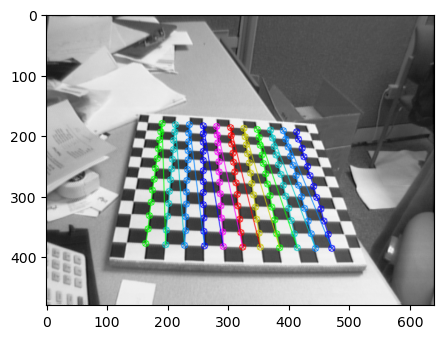

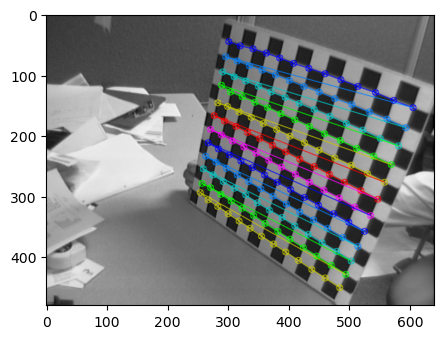

In [34]:
plot_found_corners(first_img_data, first_pattern, first_corner, second_img_data, second_pattern, second_corner)

In [35]:
# based on the resulting plots there should be some corrections between corners for them to match
# remove unnecessary dimension
first_corner = first_corner.squeeze()
second_corner = second_corner.squeeze()

# split them into groups
first_corner_list = np.split(first_corner, list(first_pattern)[1])
second_corner_list = np.split(second_corner, list(second_pattern)[1])

In [36]:
second_corner_list = [x[1:-1] for x in second_corner_list]
second_corner_list_rearranged = []
for reverse_idx in range((second_pattern[0] - 2) - 1, -1, -1):
    rearranged_column = np.stack([x[reverse_idx] for x in second_corner_list])
    second_corner_list_rearranged.append(rearranged_column)
second_corner = np.concatenate(second_corner_list_rearranged)
second_pattern = (second_pattern[1], second_pattern[0] - 2)

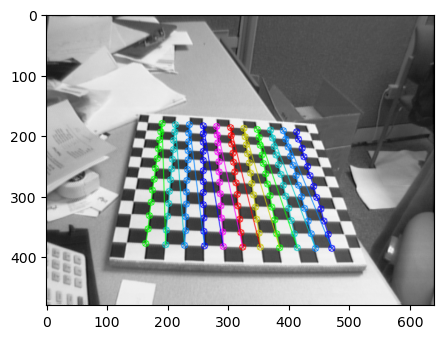

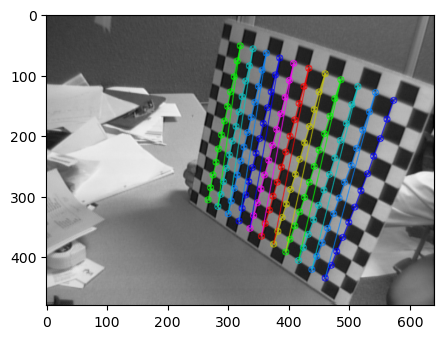

In [40]:
plot_found_corners(first_img_data, first_pattern, first_corner[:, np.newaxis, :], second_img_data, second_pattern, second_corner[:, np.newaxis, :])

In [44]:
# now the resulting corner matrices are representing the same location
# for each point we can generate vectorized notation to estimate the homography matrix
homography = get_homography(first_corner, second_corner)
# the resulting homography
print('The resulting homography matrix between image 1 and 9 is the following:\n{}'.format(homography))

The resulting homography matrix between image 1 and 9 is the following:
[[-1.17667194e-03 -2.88572561e-04 -1.62800412e-03]
 [-5.70416896e-03 -2.78731558e-01  9.60348467e-01]
 [-3.15720819e-06  7.64860906e-06  1.69832002e-03]]
